**AIM 5011 - Fall 2021**

**Final Project Component - Text-Only Meme Model with BERT (holdout predictions)**

**Aishwarya Singh**

Preparation:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

In [2]:
repo = os.path.dirname(os.path.abspath(''))
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
import tensorflow as tf
import keras as kr
import transformers

In [5]:
tf.keras.backend.clear_session()
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
from transformers import BertTokenizer, TFBertForSequenceClassification

In [7]:
tf.random.set_seed(0)
np.random.seed(0)

------------------------------------------------------------------------------------------

Encoder Functions:

In [8]:
# combine step for tokenization, WordPiece vector mapping, adding special tokens 
def convert_example_to_feature(review):
    return bert_tokenizer.encode_plus(review, 
                                    add_special_tokens = True,     # add [CLS], [SEP]
                                    max_length = 512,              # max length of the text that can go to BERT
                                    padding='max_length',
                                    truncation=True,
                                    return_attention_mask = True,  # add attention mask to not focus on pad tokens
                                  )

# map to the expected input to TFBertForSequenceClassification
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
              "input_ids": input_ids,
              "token_type_ids": token_type_ids,
              "attention_mask": attention_masks,
          }, label

def encode_examples(ds):
    # prepare list, so that we can build up final TensorFlow dataset from slices.
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    for review, label in ds:
        bert_input = convert_example_to_feature(review)
        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])

    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [9]:
def extract_transform(frame):
    new_strings = []
    locate_capture = re.compile('description: "([\w\s]*)[\.\?!,]*"[\n]')
    
    for i in range(frame.shape[0]):
        new_strings.append(' '.join(locate_capture.findall(frame.iloc[i].text)))
    
    dataset = pd.DataFrame({'id':frame.Name, 'text':new_strings, 'label':frame.hate})
    return dataset

------------------------------------------------------------------------------------------

Data Load:

In [10]:
api_memes_raw = pd.read_csv("https://raw.githubusercontent.com/codepharmer/AIM-5011-NLP-Final-Project/main/data/processed/google_API_response/our_images_API_response.csv")

api_memes_raw = api_memes_raw[api_memes_raw.text.notna()]
    
api_memes = extract_transform(api_memes_raw)

api_memes.shape

(769, 3)

In [11]:
api_memes

,id,text,label
0,10246724_747008182064474_2873398654888745189_n...,DONALD DUCK TEACHING SUBLIMINAL MESSAGES TO YO...,1
1,obama-meme.jpg,Sorry it took so long to get you a copy of my ...,1
2,alldone.png,YOU SLANDERED DEGRADED AND HUMILIATED ME IN FR...,1
3,brown.png,IF ITS YELLOW LET IT MELLOW IF BROWN FLUSH IT ...,1
4,patriots.png,In 2016 the American public realized that thei...,1
...,...,...,...
883,389ae57e1c001ec78fc84a56eb86060b.jpeg,THN BLACK FAST my sympathies are BLACK BLACK B...,1
884,421ba6b590f60e8ca14b864ef62b0937.jpeg,I WAS GOING TO SMOKE A JOINT WITH SOME MEXICAN...,1
885,8b0692fbb7b694714d9469223c3a365b.jpeg,Hispanic girliriends be like 02582 the last th...,1
886,3296e4cea44ab2cd64470be83d474b20.jpeg,My transgender friend keeps talking about suic...,1


In [12]:
api_memes.iloc[666].text

'NOT DOING THIS UNTIL SOMEBODY GETS ME A BOOSTER SEAT'

In [13]:
api_memes.label.sum()

68

------------------------------------------------------------------------------------------

Model Setup:

In [14]:
X_all = np.array(api_memes.text)
y_all = np.array(api_memes.label)

In [15]:
num_classes = 2

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)

In [16]:
# hyper-parameters
batch_size = 2

In [17]:
# encode dataset
ds_all = zip(X_all, y_all)

ds_all_encoded = encode_examples(ds_all).shuffle(len(X_all)).batch(batch_size)

In [18]:
## Initialize pre-built BERT-based classifier from transformers
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = num_classes)

bert_model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [19]:
# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam()

# we do not have one-hot vectors, we can use sparse categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_model.compile(loss = loss,
                   optimizer = optimizer,
                   metrics = metric)

------------------------------------------------------------------------------------------

Prediction & Evaluation:

In [20]:
bert_model.load_weights(os.path.join(repo, "models", "BERTs", "bert_short.h5"))

In [21]:
y_all_pred = bert_model.predict(ds_all_encoded,
                                batch_size = batch_size)

y_all_pred_label = y_all_pred[0].argmax(axis = 1)

Validation Dataset Confusion Matrix:


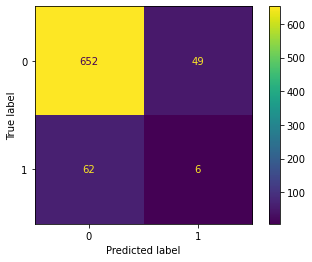

In [22]:
print("Validation Dataset Confusion Matrix:")
figure = ConfusionMatrixDisplay(confusion_matrix(y_all, y_all_pred_label))
figure.plot()
plt.show()

In [23]:
meme_text_outs = api_memes.copy()

meme_text_outs.insert(3, 'prediction', y_all_pred_label)
meme_text_outs.insert(4, 'pred_val0', np.array(y_all_pred[0][:,0]))
meme_text_outs.insert(5, 'pred_val1', np.array(y_all_pred[0][:,1]))

meme_text_outs

,id,text,label,prediction,pred_val0,pred_val1
0,10246724_747008182064474_2873398654888745189_n...,DONALD DUCK TEACHING SUBLIMINAL MESSAGES TO YO...,1,0,-0.021378,-0.165373
1,obama-meme.jpg,Sorry it took so long to get you a copy of my ...,1,0,1.420954,-1.533644
2,alldone.png,YOU SLANDERED DEGRADED AND HUMILIATED ME IN FR...,1,0,0.644745,-0.766473
3,brown.png,IF ITS YELLOW LET IT MELLOW IF BROWN FLUSH IT ...,1,0,0.431868,-0.386941
4,patriots.png,In 2016 the American public realized that thei...,1,0,0.460975,-0.626266
...,...,...,...,...,...,...
883,389ae57e1c001ec78fc84a56eb86060b.jpeg,THN BLACK FAST my sympathies are BLACK BLACK B...,1,0,0.475200,-0.544624
884,421ba6b590f60e8ca14b864ef62b0937.jpeg,I WAS GOING TO SMOKE A JOINT WITH SOME MEXICAN...,1,0,0.139149,-0.131163
885,8b0692fbb7b694714d9469223c3a365b.jpeg,Hispanic girliriends be like 02582 the last th...,1,0,0.542008,-0.657861
886,3296e4cea44ab2cd64470be83d474b20.jpeg,My transgender friend keeps talking about suic...,1,0,1.240212,-1.272731


In [24]:
meme_text_outs.to_csv(os.path.join(repo, "data", "processed", "Text_Processing_BERT_Validation_Set.csv"))